# Estimating flood hazard from anonymized insurance data: A statistical simulation

## Simulated data

In this notebook, we use a simulation-based approach to evaluate statistical methods for estimating flood damage probabilities from anonymized insurance data. This allows us to compare the performance of different regression approaches in situations where the true values of estimated parameters are known—something that would not be possible under real-world conditions. In this simplified example, flood damage probabilities are modeled as a function of a single normally-distributed covariate, $X$, which is assumed to represent elevation: 

$$ X \sim \mathcal{N}(0,1) $$

The values of $X$ are simulated across a 100 $\times$ 100 square grid representing the study domain. In order to ensure that the study domain includes gradual transitions between areas of high and low elevation, spatial autocorrelation between values of $X$ is modeled using a spherical covariance function with a range of 50 gridcells. A total of 5000 gridcells are randomly selected as building points. At each building point, the probability of flood damage is computed as a logistic function of elevation: 

$$ p_i = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 x_i\right)}} $$

where $p_i$ represents the true flood hazard at building $i$, $x_i$ represents the building's elevation, and $\beta_0$ and $\beta_1$ are parameters controlling the relationship between elevation and flood hazard whose values are fixed at $-3$ and $-2$ respectively. In reality, $p_i$, $\beta_0$, and $\beta_1$ are never observed directly, and must be estimated based on past realizations of flood damage using regression analysis. Our objective is to identify regression approaches that yield accurate and unbiased estimates of these parameters. 

For each building point, the presence or absence of flood damage is simulated as a Bernoulli random variable whose expected value is equal to the true flood damage probabilty at that location:  

$$ Y_i \sim \text{Bernoulli}(p_i) $$

Similarly, the insurance status of each building is simulated as a Bernoulli random variable whose expected value is equal to 20%. Because we are unlikely to have access to information on the flood damage status of uninsured buildings, all regression models are fit using data from only insured buildings. 

To evaluate how imperfect information on the location of individual policyholders affects the performance of regression approaches, we divide our study domain into 25 equally-sized square blocks that are used to create an "anonymized" version of the insurance data. These polygons represent the coarse geographic identifiers that are typically reported by [OpenFEMA](https://www.fema.gov/openfema-data-page/fima-nfip-redacted-policies-v2) (e.g., census block groups, flood zones, etc.). 

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import cholesky
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from itertools import product
from shapely.geometry import box
import os

%matplotlib inline

In [2]:
### *** HELPER FUNCTIONS *** ###

def create_regular_grid(x_points,y_points,crs='EPSG:4326'):
    """
    param: x_points: numpy array of grid cell x coordinates (e.g., longitude). Assumes uniform spacing. 
    param: y_points: numpy array of grid cell y coordinates (e.g., latitude). Assumes uniform spacing. 
    param: crs: coordinate reference system of grid. 
    returns: grid_gdf: grid cell geodataframe. 
    """
    # Calculate grid cell spacing in x and y directions
    width = np.diff(x_points)[0]
    height = np.diff(y_points)[0]
    
    # Create list specifying coordinates of grid cell centers
    coordinate_pairs = [(x,y) for x,y in product(x_points,y_points)]
    x_vals = [x for x,y in coordinate_pairs]
    y_vals = [y for x,y in coordinate_pairs]
    grid_cells = [box(x-width/2,y-height/2,x+width/2,y+height/2) for x,y in coordinate_pairs]
    grid_gdf = gpd.GeoDataFrame(data={'grid_x':x_vals,'grid_y':y_vals},geometry=grid_cells, crs=crs)
    
    return(grid_gdf)

class UnivariateLogisticRegression:
    """
    Univariate logistic regression class that allows user to manually adjust coefficients if desired
    """
    
    def __init__(self,beta0,beta1):
        self.beta0 = beta0
        self.beta1 = beta1

    def fit(self,x,y,sample_weight=None):

        if sample_weight is None:
            sample_weight = np.ones(len(x))
        
        mod = LogisticRegression()
        mod.fit(x.reshape(len(x),1),y,sample_weight=sample_weight)
        
        self.beta0 = mod.intercept_[0]
        self.beta1 = mod.coef_[0][0]

    def predict_proba(self,x):
        p = 1/(1+np.exp(-1*(self.beta0 + self.beta1*x)))
        return p

### *** FUNCTIONS AND CLASSES FOR SIMULATING SPATIAL RANDOM FIELDS *** ###

class SphCovFun:
    """
     Spherical covariance function class (child class of CovFun)
    """
    def __init__(self,a):
        """
        param: a: scale parameter determining speed at which spatial / temporal dependence decays
        param: a_bounds: bounds on "a" if fitting as a free parameter 
        """
        self.a = a
    
    def cov(self,h):
        """
        Return value of covariance function
        param: h: value of spatial or temporal distance between points
        """
        c = (1-np.heaviside(h - self.a,0))*(1 - 1.5*h/self.a + 0.5*h**3/self.a**3)
        return c

    def vgm(self,h):
        """
        Return value of the variogram function
        param: h: value of spatial or temporal distance between points
        """
        v = self.cov(0) - self.cov(h)
        return v
    
class ExpCovFun:
    """
    Exponential covariance function class
    """
    def __init__(self,a):
        """
        param: a: scale parameter determining speed at which spatial / temporal dependence decays
        param: a_bounds: bounds on "a" if fitting as a free parameter 
        """
        self.a = a
    
    def cov(self,h):
        """
        Return value of covariance function
        param: h: value of spatial or temporal distance between points
        """
        c = np.exp(-h/self.a)
        return c

    def vgm(self,h):
        """
        Return value of the variogram function
        param: h: value of spatial or temporal distance between points
        """
        v = self.cov(0) - self.cov(h)
        return v

def simulate_spatial_random_field(cov_fun,Nx,Ny,seed=None):
    """
    This function simulates a spatially-correlated gaussian random variable.

    param: cov_fun: fully parameterized covariance function / variogram model (instance of class CovFun)
    param: Nx: Number of gridcells in x-direction
    param: Ny: Number of gridcells in y-direction
    param: seed: optional fixed random seed for reproducibility
    returns: XX: x-coordinate grid (Nx x Ny array)
    returns: YY: y-coordinate grid (Nx x Ny array)
    returns: ZZ: simulated values of random variable (Nx x Ny array)
    """

    if seed is not None:
        np.random.seed(seed=seed)

    XX,YY = np.meshgrid(np.arange(0,Nx,1),np.arange(0,Ny,1))
    coords = np.vstack([XX.ravel(), YY.ravel()]).T
    
    dmat = squareform(pdist(coords))
    cov_mat = cov_fun.cov(dmat)
    
    L = cholesky(cov_mat, lower=True, check_finite=True)
    u = stats.norm.rvs(size=len(coords))
    
    z = L @ u
    ZZ = z.reshape(XX.shape)

    return XX, YY, ZZ

In [3]:
### *** GENERATE SYNTHETIC DATA *** ###

# Set random seed for reproducibility
seed = 112263
np.random.seed(seed)

# Simulate a spatial random field representing an enironmental predictor.
# For simplicitly, we'll refer to this as "elevation", but could be anything. 
Nx=100
Ny=100
cov_fun = SphCovFun(a=50)
XX, YY, ZZ = simulate_spatial_random_field(cov_fun,Nx,Ny)

N_coords = len(XX.ravel())
coord_indices = np.arange(N_coords)

# Randomly place buildings across study domain and sample elevations
# Save as pandas geodataframe
N_buildings = 5000
building_indices = np.random.choice(coord_indices,size=N_buildings,replace=False)
building_X = XX.ravel()[building_indices]
building_Y = YY.ravel()[building_indices]
building_Z = ZZ.ravel()[building_indices]
buildings = gpd.GeoDataFrame(data={'elevation':building_Z},geometry=gpd.points_from_xy(building_X,building_Y))
buildings.index.name = 'building_id'
buildings.reset_index(inplace=True)

# Specify flood hazard function, and draw for whether each building was flooded
beta0 = -3  # Intercept in logistic model
beta1 = -2  # Coefficient in logistic model
flood_hazard = UnivariateLogisticRegression(beta0,beta1)
buildings['flood_hazard'] = flood_hazard.predict_proba(buildings['elevation'])
buildings['flooded'] = stats.bernoulli.rvs(p=buildings['flood_hazard'].to_numpy(),size=len(buildings))

# Draw for whether each building is insured or uninsured
insured_prob = 0.2
buildings['insured'] = stats.bernoulli.rvs(p=insured_prob,size=len(buildings))

# Create polygons that we'll use for aggregation
# (these will be square tiles, but could represent something like census blocks) 
width = 20
height = 20
polygons = create_regular_grid(np.arange(0+width/2,Nx,width),np.arange(0+height/2,Ny,height),crs=None)
polygons['polygon_id'] = polygons.index.values

# Join polygon info to buildings
buildings = gpd.sjoin(buildings,polygons[['polygon_id','geometry']],how='left').drop(columns='index_right')

# Sometimes a building will fall on the border of two polygons, resulting in duplicate rows
# Keep only the first polygon that a building joins to
buildings.drop_duplicates(subset='building_id',inplace=True)

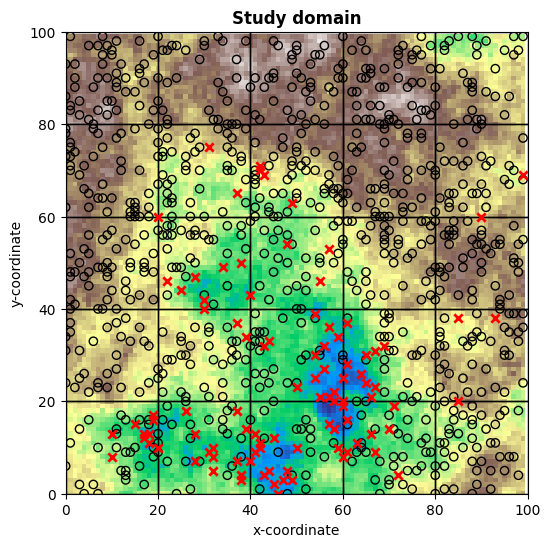

In [4]:
### *** CREATE PLOT OF STUDY DOMAIN *** ###

fig, ax = plt.subplots(figsize=(6,6))

ax.pcolormesh(XX,YY,ZZ,cmap='terrain',vmin=-3,vmax=3)

polygons.plot(ax=ax,facecolor='none',edgecolor='k')

m1 = (buildings['insured']==1)&(buildings['flooded']==1)
m2 = (buildings['insured']==1)&(buildings['flooded']==0)
buildings[m2].plot(ax=ax,marker='o',facecolor='none',edgecolor='k')
buildings[m1].plot(ax=ax,marker='x',color='r',linewidth=2)

ax.set_xlim([0,Nx])
ax.set_ylim([0,Ny])

ax.set_xlabel('x-coordinate')
ax.set_ylabel('y-coordinate')
ax.set_title('Study domain',fontweight='bold')

fig.show()

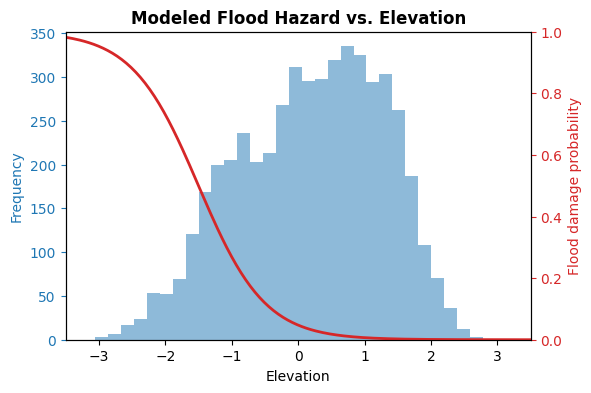

In [5]:
### *** CREATE PLOT OF FLOOD HAZARD FUNCTION *** ###

fig,ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()

ax1.hist(buildings['elevation'],bins=30,alpha=0.5)
ax1.set_xlabel('Elevation')
ax1.set_ylabel('Frequency',color='C0')
ax1.tick_params(axis='y', colors='C0')

xmin = -3.5
xmax = 3.5
xvals = np.linspace(xmin,xmax,200)
yvals = flood_hazard.predict_proba(xvals)

ax2.plot(xvals,yvals,color='C3',lw=2)
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([0,1])
ax2.set_ylabel('Flood damage probability',color='C3')
ax2.tick_params(axis='y', colors='C3')

ax1.set_title('Modeled Flood Hazard vs. Elevation',fontweight='bold')

fig.show()

In [6]:
### *** DISPLAY STRUCTURE OF SIMULATED DATA *** ###
buildings

,building_id,elevation,geometry,flood_hazard,flooded,insured,polygon_id
0,0,-0.118662,POINT (67 41),0.059375,0,0,17
1,1,-0.809552,POINT (26 20),0.200865,0,1,5
2,2,0.333070,POINT (92 32),0.024937,0,0,21
3,3,1.679588,POINT (67 90),0.001728,0,0,19
4,4,-1.087517,POINT (56 1),0.304710,0,0,10
...,...,...,...,...,...,...,...
4995,4995,-1.457806,POINT (38 43),0.478916,1,0,7
4996,4996,0.401274,POINT (97 31),0.021827,0,0,21
4997,4997,-0.683063,POINT (64 3),0.163300,0,0,15
4998,4998,-0.129155,POINT (30 31),0.060558,0,0,6


## Performance metrics

To evaluate the performance of different regression approaches, we will compute the mean squared error (MSE) between the predicted flood damage probability ($\hat{p_i}$) and true flood damage probability ($p_i$) of each building: 

$$ MSE = \frac{1}{n} \sum_{i=1}^n \left( p_i - \hat{p_i}\right)^2 $$

Because we are dealing with probabilities that are typically small, it is helpful to anchor the MSE of each regression model against that of a naive reference model. This is done by computing a skill score (SS) that reflects the degree to which a skilled model reduces MSE compared to a naive model:

$$ SS = 1 - \frac{MSE_{model}}{MSE_{ref}} $$

where $MSE_{ref}$ represents the MSE of a naive model that predicts all buildings to have a flood damage probability equal to the sample mean (i.e., an intercept-only model). 

$$ MSE_{ref} = \frac{1}{n} \sum_{i=1}^n \left( p_i - \bar{p}\right)^2 $$

In [7]:
def performance_metrics(p_true,p_pred,p_bar=None):
    """
    param: p_true: true flood damage probability
    param: p_pred: predicted flood damage probability
    param: p_bar: naive prediction of flood damage probability (e.g., share of buildings flooded)
    """

    if p_bar is None:
        p_bar = np.mean(p_true)

    MSE = np.mean((p_true-p_pred)**2)
    MSE_ref = np.mean((p_true-p_bar)**2)

    performance = {}
    performance['MSE'] = MSE
    performance['SS'] = 1 - MSE/MSE_ref
    
    return(performance)

## Model A: Address-level data

First, we evaluate the predictive performance of a logistic regression model fit to address-level insurance data: 

$$ \log \left( \frac{p_i}{1 - p_i} \right) = \beta_0 + \beta_1 x_i$$

Because we simulated the flood hazard of each building as a logistic function of elevation, we know that the above regression model is correctly specified. However, the estimated values of $\beta_0$ and $\beta_1$ may differ slightly from their true values due to the limited sample size of insured buildings. 

In [8]:
### *** MODEL A: ADDRESS-LEVEL DATA ***  ###

# Get observations from insured buildings (dropping uninsured)
address_level_insurance_data = buildings[buildings['insured']==1].reset_index(drop=True)
address_level_insurance_data.index.name = 'record_id'
address_level_insurance_data.reset_index(inplace=True)
address_level_insurance_data

,record_id,building_id,elevation,geometry,flood_hazard,flooded,insured,polygon_id
0,0,1,-0.809552,POINT (26 20),0.200865,0,1,5
1,1,5,1.111205,POINT (19 95),0.005365,0,1,4
2,2,17,-0.534378,POINT (99 99),0.126613,0,1,24
3,3,20,0.210345,POINT (92 72),0.031655,0,1,23
4,4,26,0.853125,POINT (9 50),0.008958,0,1,2
...,...,...,...,...,...,...,...,...
962,962,4951,-0.162002,POINT (27 60),0.064405,0,1,7
963,963,4959,-0.135666,POINT (41 67),0.061303,0,1,13
964,964,4964,-0.839822,POINT (80 6),0.210759,0,1,15
965,965,4967,0.511672,POINT (81 32),0.017578,0,1,21


In [9]:
# Attempt to fit a logistic regression model
modA = UnivariateLogisticRegression(0,0)
x = address_level_insurance_data['elevation'].to_numpy()
y = address_level_insurance_data['flooded'].to_numpy()
modA.fit(x,y)

# Compute performance metrics
p_pred = modA.predict_proba(buildings['elevation'].to_numpy())
p_true = buildings['flood_hazard'].to_numpy()
p_bar = np.mean(y)
perf_modA = performance_metrics(p_true,p_pred,p_bar=p_bar)

# Print results
print('\n*** Model A: Address-level data ***\n')
print(f'beta0 = {modA.beta0:.3f}')
print(f'beta1 = {modA.beta1:.3f}')
print(f'MSE = {perf_modA['MSE']:.6f}')
print(f'SS  = {perf_modA['SS']:.6f}')


*** Model A: Address-level data ***

beta0 = -3.243
beta1 = -1.972
MSE = 0.000848
SS  = 0.977296


## Model B: Anonymized data with stochastic assignment of buildings

To evaluate how imperfect information on the location of individual policyholders affects the performance of regression approaches, we will attempt to fit a logistic regression model to an "anonymized" version of the insurance data where building-specific information has been removed. This means that we do not know which building generated a given presence or absence point; however, we can narrow down the list of potential building candidates based on the `polygon_id` associated with each insurance record. Within each polygon, we randomly assign presence-absence points to buildings in order to assign building-specific covariate values such as elevation. This process assumes all buildings within a polygon are equally likely to be selected and is repeated 1,000 times to ensure that the space of possible assignments is adequately explored.


In [10]:
### *** MODEL B: ANONYMIZED DATA WITH STOCHASTIC ASSIGNMENT OF BUILDINGS *** ###

# Drop information about building location and elevation.
# Now we only know the flood damage status of each record and the polygon where it is located. 
anonymized_insurance_data = address_level_insurance_data[['record_id','flooded','polygon_id']]
anonymized_insurance_data

,record_id,flooded,polygon_id
0,0,0,5
1,1,0,4
2,2,0,24
3,3,0,23
4,4,0,2
...,...,...,...
962,962,0,7
963,963,0,13
964,964,0,15
965,965,0,21


In [11]:
# Get counts of presence / absence points within each polygon
polygon_pa_counts = anonymized_insurance_data.groupby('polygon_id').agg({'flooded':['count','sum']})
polygon_pa_counts.columns = ['num_records','num_presence']
polygon_pa_counts['num_absence'] = polygon_pa_counts['num_records']-polygon_pa_counts['num_presence']
polygon_pa_counts

,num_records,num_presence,num_absence
polygon_id,,,
0,41,10,31
1,34,0,34
2,46,1,45
3,43,0,43
4,46,0,46
5,35,13,22
6,35,3,32
7,39,7,32
8,41,2,39


In [12]:
# Create lookup table that returns buildings associated with each polygon
building_lookup = buildings[['polygon_id','building_id','elevation']].sort_values(by='polygon_id').set_index('polygon_id')
building_lookup

,building_id,elevation
polygon_id,,
0,21,-0.729817
0,1320,-0.992384
0,1257,-1.504478
0,13,0.532332
0,4392,-0.591359
...,...,...
24,4386,0.845247
24,4380,0.346205
24,4379,0.341939


In [13]:
# Create functions that we can use to randomly assign presence-absence points to buildings
# within each polygon

def assign_presence_absence_points(polygon_id,num_presence,num_absence,building_lookup):
    """
    param: polygon_id: unique id of polygon of interest
    param: num_presence: number of presence points to sample within polygon
    param: num_absence: number of absence points to sample within polygon
    param: building_lookup: pandas dataframe listing buildings associated with each polygon, indexed by polygon_id
    """

    sampled_buildings = building_lookup.loc[polygon_id].sample(num_presence+num_absence)
    flooded_status = np.zeros(len(sampled_buildings),dtype=int)
    flooded_inds = np.random.choice(np.arange(len(sampled_buildings)),size=num_presence,replace=False)
    flooded_status[flooded_inds] = 1
    sampled_buildings['flooded'] = flooded_status
    
    return(sampled_buildings)

def monte_carlo_sample_buildings(polygon_pa_counts,building_lookup,num_replicates=1):
    """
    param: polygon_pa_counts: pandas dataframe listing number of presence-absence points in each polygon, indexed by polygon_id
    param: building_lookup: pandas dataframe listing buildings associated with each polygon, indexed by polygon_id
    param: num_replicates: number of times to repeat monte carlo sampling
    """
    
    df_list = []
    
    for i in range(num_replicates):
        
        df = pd.concat([assign_presence_absence_points(polygon_id,row['num_presence'],row['num_absence'],building_lookup) for polygon_id,row in polygon_pa_counts.iterrows()])
        df.reset_index(inplace=True)
        df['replicate'] = i+1
        df_list.append(df)

    df = pd.concat(df_list).reset_index(drop=True).rename(columns={'building_id':'candidate_building_id'})

    return(df)

In [14]:
# Stochastically assign presence-absence points to buildings. 
# Do this 1000 times to ensure we adequately sample potential options. 
mc_data = monte_carlo_sample_buildings(polygon_pa_counts,building_lookup,num_replicates=1000)
mc_data

,polygon_id,candidate_building_id,elevation,flooded,replicate
0,0,4518,0.048292,0,1
1,0,714,-0.699334,1,1
2,0,4103,-0.113062,0,1
3,0,397,0.131431,1,1
4,0,2843,-1.181779,0,1
...,...,...,...,...,...
966995,24,2158,0.794441,0,1000
966996,24,3639,0.312872,0,1000
966997,24,2817,1.320637,0,1000
966998,24,4994,1.193162,0,1000


In [15]:
# Attempt to fit a logistic regression model
modB = UnivariateLogisticRegression(0,0)
x = mc_data['elevation'].to_numpy()
y = mc_data['flooded'].to_numpy()
modB.fit(x,y)

# Compute performance metrics
p_pred = modB.predict_proba(buildings['elevation'].to_numpy())
perf_modB = performance_metrics(p_true,p_pred,p_bar=p_bar)

# Print results
print('\n*** Model B: Anonymized data with stochastic assignment of buildings ***\n')
print(f'beta0 = {modB.beta0:.3f}')
print(f'beta1 = {modB.beta1:.3f}')
print(f'MSE = {perf_modB['MSE']:.6f}')
print(f'SS  = {perf_modB['SS']:.6f}')


*** Model B: Anonymized data with stochastic assignment of buildings ***

beta0 = -2.477
beta1 = -1.158
MSE = 0.005852
SS  = 0.843341


## Model C: Weighted regression with uniform weights

Next, we explore an alternative method for dealing with anonymized insurance data that formulates the problem as a weighted regression. To do this, we start by defining the set of $K_i$ building candidates that could potentially be associated with insurance record $i$ based on its `polygon_id`:

$$ C_i = \left\{b_{i1}, b_{i2}, b_{i3}, ..., b_{iK_i}\right\}$$

where $b_{ij}$ represents the $j$th building candidate for insurance record $i$. Next, we define a latent categorical variable $Z_i$ that represents the specific building in the candidate set that generated insurance record $i$: 

$$ Z_i \in C_i $$

Because the insurance data is anonymized, we cannot observe the value of $Z_i$ directly. However, if we assume that all building candidates are equally likely, we can define the "weight" associated with potential values of $Z_i$ as follows:

$$ w_{ij} = \text{Prob}(Z_i = b_{ij}) = \frac{1}{K_i} $$

This implies that an insurance record with 10 building candidates will give a weight of 0.1 to each potential record-building match. This approach weights each potential match equally, even if some potential matches are unrealistic (e.g., an insurance record that flooded is unlikely to have been generated by a building with a very high elevation). 

The above weights are used within a weighted logistic regression that estimates $\beta_0$ and $\beta_1$ by maximizing the following log-likelihood function: 

$$ \ell \left(\beta_0, \beta_1\right) = \sum_{i=1}^{n} \sum_{j=1}^{K_i} w_{ij} \left[ y_i \log p_{ij} + \left(1-y_i\right)\log\left(1-p_{ij}\right)\right]$$

where $y_i$ represents the observed outcome of insurance record $i$ (i.e., flooded or not flooded), and $p_{ij}$ represents the probability that building candidate $j$ flooded based on its elevation ($x_{ij}$) and current estimates of $\beta_0$ and $\beta_1$: 

$$ p_{ij} = \frac{1}{1 + e^{-\left(\beta_0 + \beta_1 x_{ij}\right)}} $$

Although all of this mathematical notation might seem like overkill for what is a fairly simple regression problem, it is helpful to introduce these concepts so that we can later derive improved methods for weighting building candidates.

The Monte Carlo approach employed by model B should be asymptotically equivalent to the weighted regression shown above when the number of replicates is large. As such, we can expect models B and C to return similar estimates of $\beta_0$ and $\beta_1$. 

In [16]:
### *** MODEL C: WEIGHTED REGRSSION WITH UNIFORM WEIGHTS *** ###

# Create dataframe where each row represents a potential match between a 
# specific insurance record and building located within the same polygon
candidate_df = pd.merge(anonymized_insurance_data,building_lookup,on='polygon_id',how='left').rename(columns={'building_id':'candidate_building_id'})

# Assume that for a given record, all buildings within its polygon are equally likely
candidate_df['candidate_weight'] = 1

# Display structure of data
candidate_df

,record_id,flooded,polygon_id,candidate_building_id,elevation,candidate_weight
0,0,0,5,4373,-0.960825,1
1,0,0,5,2834,-0.755422,1
2,0,0,5,2892,-1.632868,1
3,0,0,5,694,-1.230304,1
4,0,0,5,1330,-1.620621,1
...,...,...,...,...,...,...
194132,966,1,20,2262,-0.550616,1
194133,966,1,20,2295,-0.427955,1
194134,966,1,20,352,0.672331,1
194135,966,1,20,335,0.480359,1


In [17]:
# Define a function that will allow us to normalize the weight assigned to each record-building 
# match so that the weights associated with each insurance record sum to 1.0 

def normalize_weights(df,id_col='record_id',weight_col='candidate_weight'):
    """
    This function normalizes the weights assigned to potential building matches so that 
    the weights associated with each insurance record sum to 1.0. 
    
    param: df: dataframe where each row represents a potential record-building match
    param: id_col: name of column containing unique ID of each record
    param: weight_col: name of column containing weight assigned to each building
    """
    
    df[weight_col] = df.groupby(id_col)[weight_col].transform(lambda x: x / x.sum())
    return(df)

# Apply function to dataframe
candidate_df = normalize_weights(candidate_df)
candidate_df

,record_id,flooded,polygon_id,candidate_building_id,elevation,candidate_weight
0,0,0,5,4373,-0.960825,0.004878
1,0,0,5,2834,-0.755422,0.004878
2,0,0,5,2892,-1.632868,0.004878
3,0,0,5,694,-1.230304,0.004878
4,0,0,5,1330,-1.620621,0.004878
...,...,...,...,...,...,...
194132,966,1,20,2262,-0.550616,0.005051
194133,966,1,20,2295,-0.427955,0.005051
194134,966,1,20,352,0.672331,0.005051
194135,966,1,20,335,0.480359,0.005051


In [18]:
# Attempt to fit a logistic regression model
modC = UnivariateLogisticRegression(0,0)
x = candidate_df['elevation'].to_numpy()
y = candidate_df['flooded'].to_numpy()
w = candidate_df['candidate_weight'].to_numpy()
modC.fit(x,y,sample_weight=w)

# Compute performance metrics
p_pred = modC.predict_proba(buildings['elevation'].to_numpy())
perf_modC = performance_metrics(p_true,p_pred,p_bar=p_bar)

# Print results
print('\n*** Model C: Weighted regression with uniform weights ***\n')
print(f'beta0 = {modC.beta0:.3f}')
print(f'beta1 = {modC.beta1:.3f}')
print(f'MSE = {perf_modC['MSE']:.6f}')
print(f'SS  = {perf_modC['SS']:.6f}')


*** Model C: Weighted regression with uniform weights ***

beta0 = -2.465
beta1 = -1.139
MSE = 0.006140
SS  = 0.835626


## Model D: Iterative reweighting via the EM algorithm

The weighting scheme used by model C treats all building candidates as equally likely. In reality, we know that this is not the case—for example, insurance claims are more likely to be generated by buildings with high flood hazard than those with low flood hazard. Ideally, we would like to assign more weight to building candidates with high flood hazard for insurance records that resulted in a claim (presence points). Similarly, we would like to assign more weight to building candidates with low flood hazard for insurance records that did not result in a claim (absence points). However, doing this accurately requires prior knowledge of the flood hazard at each building—the quantity we are trying to estimate—which creates a catch-22 scenario. 

To overcome this catch-22 scenario, we can employ iterative methods that use an initial guess of building candidate weights to produce an approximate estimate of the flood hazard at each building, which can then be used in the next iteration to produce a more accurate estimate of building candidate weights and flood hazard. By repeating this process a number of times, we can generate increasingly accurate estimates of flood hazard. 

An iterative method that is well-suited to our regression problem is the [expectation-maximization (EM) algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm). This algorithm is designed to find maximum likelihood (MLE) or maximum a posteriori (MAP) estimates of model parameters for statistical models that depend on unobserved latent variables—in our case, the building from which an insurance record was generated ($Z_i$). In each EM iteration, building candidate weights are updated via the application of Bayes rule: 


$$ w_{ij}^{new} = \underbrace{\text{Prob}(Z_i = b_{ij} \mid y_i )}_{\text{Posterior}} \propto \underbrace{\text{Prob}(y_i \mid Z_i = b_{ij})}_{\text{Likelihood}} \times \underbrace{\text{Prob}(Z_i = b_{ij})}_{\text{Prior}} $$

In the above equation, $\text{Prob}(Z_i = b_{ij})$ represents our prior belief that a building candidate generated an insurance record *before* observing any data. For simplicity, we select a uniform (non-informative) prior that assumes all building candidates are equally likely: 

$$ \text{Prob}(Z_i = b_{ij}) = \frac{1}{K_i} $$

This is equivalent to the "uniform weights" used within model C. The use of uniform priors ensures that the EM algorithm will return MLE estimates of model parameters; if we were to specify a non-uniform prior (i.e., if we believe some buildings are more likely than others) then we would instead be performing a MAP estimation. Because our priors are uniform and fixed, our updated weight estimates will be driven by the likelihood function, which reflects the probability that a given building candidate was flooded based on current estimates of model parameters: 

$$ \text{Prob}(y_i \mid Z_i = b_{ij}) = p_{ij}^{y_i}\left(1 - p_{ij}\right)^{1 - y_i} \approx \hat{p}_{ij}^{y_i}\left(1 - \hat{p}_{ij}\right)^{1 - y_i}$$

where $y_i$ represents the observed outcome for insurance record $i$ (1 = flooded, 0 = not flooded), and $\hat{p}_{ij}$ represents the estimated probability that building candidate $b_{ij}$ was flooded based on the current iteration's estimates of $\beta_0$ and $\beta_1$. The right hand side of the above equation is the probability mass function (PMF) for a Bernoulli random variable (our assumed distribution for $Y_i$). 

The pseudo-code of the EM algorithm is shown below: 

1. Initialization
    * Provide an initial guess for building candidate weights based on prior beliefs (for uniform prior, set $w_{ij} = 1 / K_i$).
    * Estimate $\beta_0$ and $\beta_1$ based on initial guess using weighted logistic regression.
2. E-step: Update building candidate weights
    * Calculate likelihood of each building candidate based on current values of $\beta_0$ and $\beta_1$.
    * Calculate updated value of building candidate weights using Bayes rule ($w_{ij}^{new} =$ Likelihood $\times$ Prior).
    * Normalize weights for each insurance record so that $\sum_j w_{ij}^{new} = 1.0$.
3. M-step: Update model coefficients
    * Fit a weighted logistic regression using updated building candidate weights.
    * Record updated values of $\beta_0$ and $\beta_1$.
4. Test for convergence
    * Check whether $\text{max}\left(|w^{old} - w^{new}|\right)$ is less than the desired error tolerance.
    * If not, repeat steps 2-3 until convergence is reached. 
    * If so, stop and return the final estimates of $\beta_0$ and $\beta_1$.  

In [19]:
def EM_algorithm(df,mod,x_col,y_col,weight_col,id_col,tol=1e-6,maxiter=100,verbose=False):
    """
    This function estimates building candidate weights and model coefficients
    using the expectation-maximization (EM) algorithm. 

    param: df: building candidate dataframe where each row corresponds to a potential record-building match. 
    param: x_col: column name in df of the independent variable (e.g., 'elevation').
    param: y_col: column name in df of the binary outcome variable (e.g., 'flooded'). 
    param: weight_col: column in df corresponding to building candidate weights
    param: id_col: column in df used to uniquely identify insurance records
    param: tol: absolute error tolerance used to assess convergence
    param: maxiter: maximum number of EM iterations allowed. 
    param: verbose: if true, print an update at the end of each iteration. 
    returns: mod: fitted model (instance of UnivariateLogisticRegression class)
    returns: df: building candidate dataframe containing final values of building candidate weights. 
    """

    x = df[x_col].to_numpy()
    y = df[y_col].to_numpy()

    ## Initialization

    # Specify a uniform, fixed prior for weights
    df[weight_col] = 1
    df = normalize_weights(df,id_col=id_col,weight_col=weight_col)
    prior = df[weight_col].to_numpy()

    # Fit model using uniform weights
    mod.fit(x,y,sample_weight=prior)

    # Print initial values of model parameters
    if verbose: 
        print('\n*** EXPECTATION-MAXIMIZATION ALGORITHM ***\n',flush=True)
        print(f'(0) beta0={mod.beta0:.3f}  beta1={mod.beta1:.3f}',flush=True)

    keepgoing = True
    converged = False
    numiter = 1

    while keepgoing and (numiter <= maxiter): 

        ## E-step: Update sample weights
    
        # Record current values of building candidate weights.  
        # (will eventually use to assess convergence)
        w_old = df[weight_col].to_numpy()
    
        # Compute likelihood of observed outcomes at each building candidate
        # based on current values of model parameters. 
        p = mod.predict_proba(x)
        likelihood = stats.bernoulli.pmf(y,p)
    
        # Bayesian update of weights
        df[weight_col] = likelihood*prior
        df = normalize_weights(df,id_col=id_col,weight_col=weight_col)
        w_new = df[weight_col].to_numpy()
    
        ## M-step: Update model parameters
    
        # Fit the model again using new weights
        mod.fit(x,y,sample_weight=w_new)
    
        ## Check for convergence
        abs_change = np.abs(w_new-w_old)
    
        if max(abs_change) < tol:
            keepgoing = False
            converged = True

        # Print update
        if verbose: 
            print(f'({numiter}) beta0={mod.beta0:.3f}  beta1={mod.beta1:.3f}  max(abs(w_new-w_old))={max(abs_change):.6f}',flush=True)

        # Increment counter
        numiter += 1

    if verbose:
        if converged: 
            print(f'\n*** Converged (tol={tol}) ***\n',flush=True)
        else:
            print(f'\n*** Failed to converge (maxiter={maxiter}) ***\n',flush=True)
            
    return(mod,df)

In [20]:
# Fit model parameters and weights using EM algorithm
modD = UnivariateLogisticRegression(0,0)
modD,candidate_df = EM_algorithm(candidate_df,modD,'elevation','flooded','candidate_weight','record_id',verbose=True)


*** EXPECTATION-MAXIMIZATION ALGORITHM ***

(0) beta0=-2.465  beta1=-1.139
(1) beta0=-2.825  beta1=-1.572  max(abs(w_new-w_old))=0.013453
(2) beta0=-2.985  beta1=-1.759  max(abs(w_new-w_old))=0.008952
(3) beta0=-3.061  beta1=-1.844  max(abs(w_new-w_old))=0.004967
(4) beta0=-3.094  beta1=-1.882  max(abs(w_new-w_old))=0.002523
(5) beta0=-3.109  beta1=-1.899  max(abs(w_new-w_old))=0.001174
(6) beta0=-3.116  beta1=-1.906  max(abs(w_new-w_old))=0.000530
(7) beta0=-3.119  beta1=-1.909  max(abs(w_new-w_old))=0.000237
(8) beta0=-3.120  beta1=-1.911  max(abs(w_new-w_old))=0.000105
(9) beta0=-3.120  beta1=-1.911  max(abs(w_new-w_old))=0.000047
(10) beta0=-3.121  beta1=-1.912  max(abs(w_new-w_old))=0.000021
(11) beta0=-3.121  beta1=-1.912  max(abs(w_new-w_old))=0.000009
(12) beta0=-3.121  beta1=-1.912  max(abs(w_new-w_old))=0.000004
(13) beta0=-3.121  beta1=-1.912  max(abs(w_new-w_old))=0.000002
(14) beta0=-3.121  beta1=-1.912  max(abs(w_new-w_old))=0.000001

*** Converged (tol=1e-06) ***



In [21]:
# Compute performance metrics
p_pred = modD.predict_proba(buildings['elevation'].to_numpy())
perf_modD = performance_metrics(p_true,p_pred,p_bar=p_bar)

# Print results
print('\n*** Model D: Iterative reweighting via the EM algorithm ***\n')
print(f'beta0 = {modD.beta0:.3f}')
print(f'beta1 = {modD.beta1:.3f}')
print(f'MSE = {perf_modD['MSE']:.6f}')
print(f'SS  = {perf_modD['SS']:.6f}')


*** Model D: Iterative reweighting via the EM algorithm ***

beta0 = -3.121
beta1 = -1.912
MSE = 0.000611
SS  = 0.983655


# Performance comparison

In order to compare the relative performance of models A-D, we fit the models to 1000 simulated datasets generated using different random seeds. This allows us to evaluate the sampling distribution of $\hat{\beta_0}$ and $\hat{\beta_1}$ under different regression approaches. 

In [22]:
# Read in model performance data
modA_df = pd.read_csv('model_A_performance.txt').sort_values(by='rseed').drop_duplicates().set_index('rseed')
modB_df = pd.read_csv('model_B_performance.txt').sort_values(by='rseed').drop_duplicates().set_index('rseed')
modC_df = pd.read_csv('model_C_performance.txt').sort_values(by='rseed').drop_duplicates().set_index('rseed')
modD_df = pd.read_csv('model_D_performance.txt').sort_values(by='rseed').drop_duplicates().set_index('rseed')

# Create dataframes where rows correspond to random seeds and columns to models to facilitate comparison
beta0_df = pd.DataFrame({'A':modA_df['beta0'],'B':modB_df['beta0'],'C':modC_df['beta0'],'D':modD_df['beta0']})
beta1_df = pd.DataFrame({'A':modA_df['beta1'],'B':modB_df['beta1'],'C':modC_df['beta1'],'D':modD_df['beta1']})
MSE_df = pd.DataFrame({'A':modA_df['MSE'],'B':modB_df['MSE'],'C':modC_df['MSE'],'D':modD_df['MSE']})

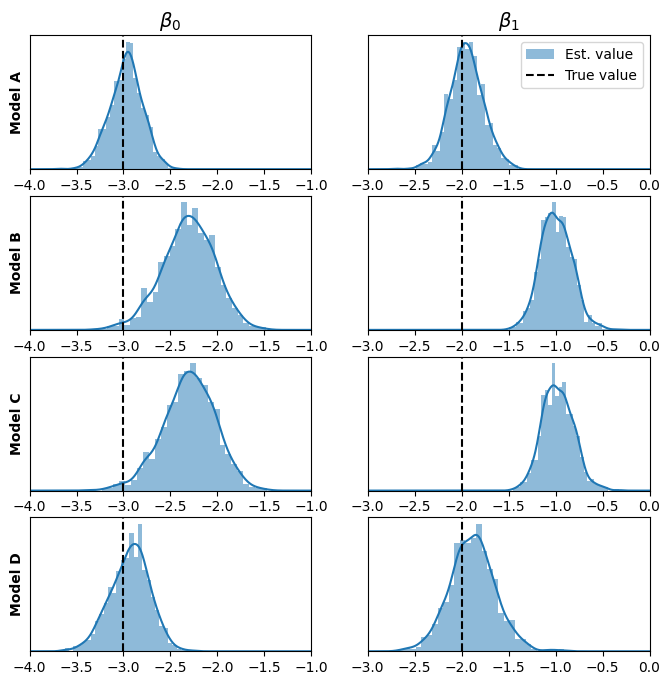

In [23]:
### *** PLOT SAMPLING DISTRIBUTION OF MODEL COEFFICIENTS *** ###

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(8,8))

model_names = ['A','B','C','D']
param_names = ['beta0','beta1']
param_label = [r'$\beta_0$',r'$\beta_1$']
param_colors = ['C0','C0']
param_data = [beta0_df,beta1_df]
param_truth = [beta0,beta1]

x_limits = [(-4,-1),(-3,0)]

for i,model in enumerate(model_names):
    for j,param in enumerate(param_names):
        
        ax = axes[i,j]

        x = param_data[j][model]
        xmin,xmax = x_limits[j]

        pdf = stats.gaussian_kde(x)
        xvals = np.linspace(xmin,xmax,500)

        c = param_colors[j]

        ax.hist(x,density=True,alpha=0.5,color=c,label='Est. value',bins=30)
        ax.set_xlim(xmin,xmax)

        ax.plot(xvals,pdf(xvals),color=c)
        ax.axvline(x=param_truth[j],ls='--',color='k',label='True value')

        ax.set_yticks([])

        if (j==0):
            ax.set_ylabel(f'Model {model}',fontweight='bold')

        if (i==0):
            ax.set_title(param_label[j],fontweight='bold',fontsize=14)

        if (i==0) and (j==1):
            
            ax.legend()

fig.show()

In [24]:
print('*** MEAN BIAS IN ESTIMATE OF BETA_0 ***')
(beta0_df - beta0).mean()

*** MEAN BIAS IN ESTIMATE OF BETA_0 ***


A    0.027631
B    0.689967
C    0.697686
D    0.068099
dtype: float64

In [25]:
print('*** MEAN BIAS IN ESTIMATE OF BETA_1 ***')
(beta1_df - beta1).mean()

*** MEAN BIAS IN ESTIMATE OF BETA_1 ***


A    0.051928
B    1.006711
C    1.024555
D    0.116008
dtype: float64

In [26]:
print('*** AVERAGE OUT-OF-SAMPLE MSE IN PREDICTIONS OF FLOOD HAZARD ***')
MSE_df.mean()

*** AVERAGE OUT-OF-SAMPLE MSE IN PREDICTIONS OF FLOOD HAZARD ***


A    0.000268
B    0.006047
C    0.006242
D    0.000436
dtype: float64